# Kofrán Dániel, Prog I. projekt

## A projektről röviden

Jelen projekt a Premier Leauge 2019/2020-as szezonja alapján mutatja be az idei (a COVID-19 miatt még csak a 31. fordulóban járó) bajnokságot. A projekt a kevésbé gyakran használt, de mégis meccsenként mért statisztikákon keresztül szeretné bemutatni a bajnokság dinamikáját. Az adatokat a Premier League hivatalos honlapjáról scrape-eltem le.

Az elején a csapatok Győzelem - Döntetlen - Vereség mutatóit mutatom be 1-1 ábrán. Ez egy általános képet hivatott adni a csapatok teljesítményéről. A második szakasz egy hőtérkép, amely a hivatalos honlapon feltüntetett mutatók közötti kapcsolatokat kívánja megmutatni. Ez segített kiválasztani azokat a változókat, melyeket ritkán használnak a csapatok teljesítményének szemléltetésére és erősebben korrigálhat a győzelemmel. A harmadik szakasz győzelem és támadójáték közötti kapcsolatra fókuszál (a kapuralövések alapján), amelyet a védők és kapusok teljesítményével (szerelések, védések) súlyozva ábrázol. Ez az offenzív - deffenmzív taktikai egyensúly megvalósulásának szemléltetését szolgálja. A negyedik szakasz a csapatok győzelmi mutatóit, illetve a támadósorra (összes kapuralövés), a középpályára/egész csapatra (összes passz), a védősorra (összes szerelés) és a kapusokra (összes védés) jellemző 1-1 mutatón keresztül elemzi a csapatokat, egymáshoz viszonyítva.

## 0. lépés: Scrapelés

In [92]:
import requests
import json
import sys
import os
import time
import pandas as pd 
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
from selenium import webdriver
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from math import pi

In [ ]:
base_url = "https://www.premierleague.com/stats/top/clubs/"
list_of_names_stats = ("wins?se=274", "losses?se=274", "touches?se=274", 
                 "own_goals?se=274", "total_yel_card?se=274", "total_red_card?se=274",
                 "goals?se=274", "total_pass?se=274", "total_scoring_att?se=274",
                 "total_offside?se=274", "hit_woodwork?se=274", "big_chance_missed?se=274",
                 "total_tackle?se=274", "total_clearance?se=274", "clearance_off_line?se=274",
                 "dispossessed?se=274", "clean_sheet?se=274", "saves?se=274",
                 "penalty_save?se=274", "total_high_claim?se=274", "punches?se=274")
driver = webdriver.Chrome()
diction ={}
    
    
for stat in list_of_names_stats:
    print(stat)    
    jelenlegi_url = base_url + stat
    driver.get(jelenlegi_url)
    time.sleep(16)
    valtozo = driver.find_elements_by_xpath('//*[@id="mainContent"]/div[2]/div/div[2]/div[1]/div[2]/table/tbody')[0].get_attribute("innerHTML")
    soup = BeautifulSoup(valtozo)
    list_of_stats = soup.find_all("tr")
    for i in list_of_stats:
        if i.find_all("td")[1].text in diction.keys(): 
            diction[i.find_all("td")[1].text][stat.split("?")[0]] = i.find_all("td")[2].text
        else:
            diction[i.find_all("td")[1].text]={}
            diction[i.find_all("td")[1].text][stat.split("?")[0]] = i.find_all("td")[2].text

    
    

## Adat behívása és pandassá alakítása

In [6]:
with open('data.json', 'r') as fp:
    szotar = json.load(fp)

In [13]:
pandas_adat = pd.DataFrame(szotar).T

In [14]:
pandas_adat.fillna(0, inplace=True)

## 1. szakasz: Győzelem - Döntetlen - Vereség

In [40]:
pandas_adat_dontetlennel = pandas_adat
draws = (31 - (pandas_adat_dontetlennel["wins"].astype(str).astype(int) + pandas_adat_dontetlennel["losses"].astype(str).astype(int)))
pandas_adat_dontetlennel['draws'] = draws 
fank_adat= pandas_adat_dontetlennel[["wins","losses","draws"]]

In [42]:
fank_adat = fank_adat.reset_index()

In [74]:
Row_list =[] 
for index, rows in fank_adat.iterrows(): 
    my_list =[rows.wins, rows.losses, rows.draws] 
    Row_list.append(my_list) 

[['28', '1', 2], ['20', '7', 4], ['16', '8', 7], ['15', '9', 7], ['13', '8', 10], ['12', '10', 9], ['12', '6', 13], ['11', '13', 7], ['11', '11', 9], ['11', '12', 8], ['11', '9', 11], ['11', '15', 5], ['10', '12', 9], ['9', '8', 14], ['7', '18', 6], ['7', '18', 6], ['7', '12', 12], ['7', '18', 6], ['6', '14', 11], ['5', '20', 6]]


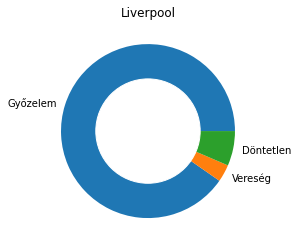

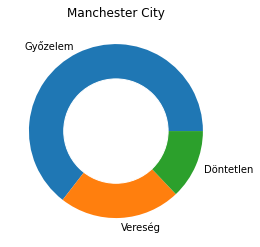

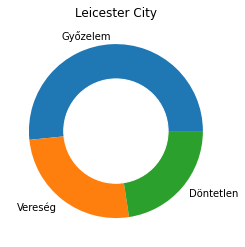

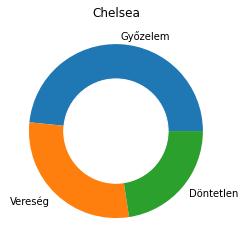

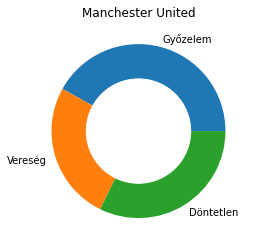

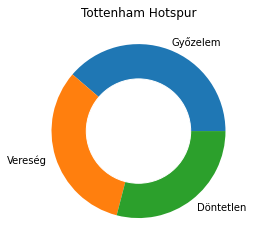

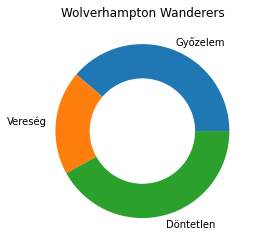

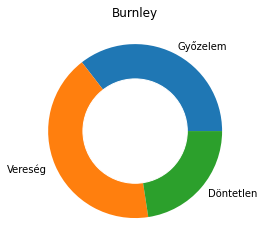

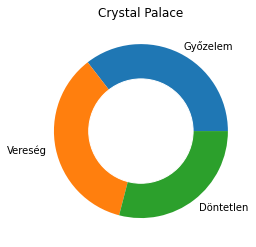

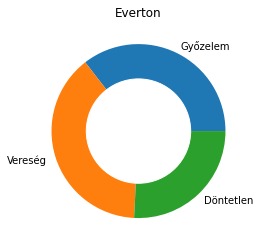

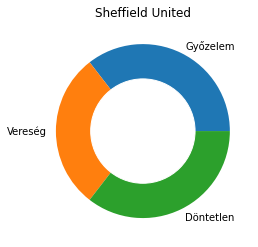

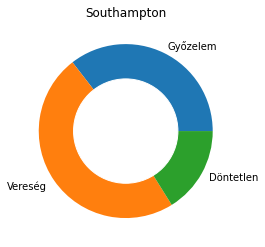

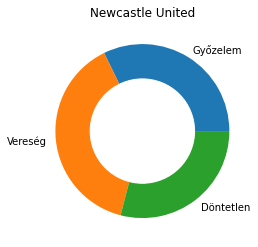

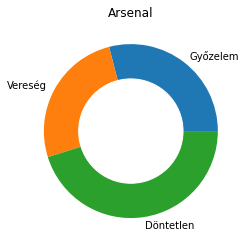

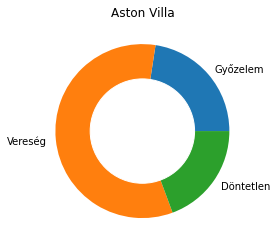

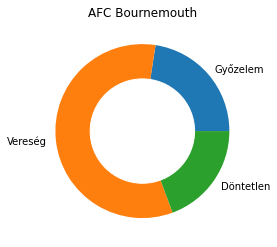

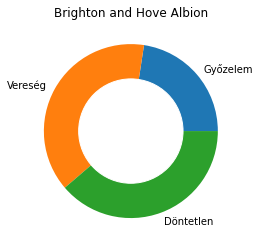

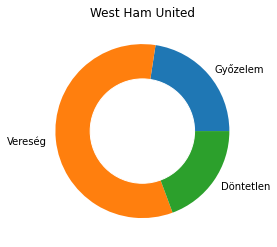

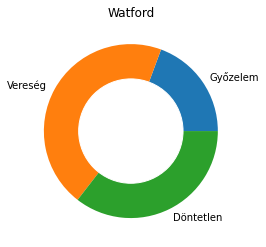

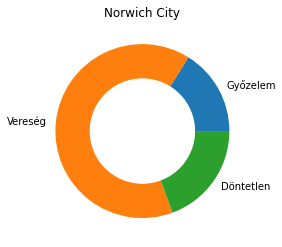

In [75]:
names='Győzelem', 'Vereség', 'Döntetlen', 
csapatnev = ["Liverpool","Manchester City","Leicester City","Chelsea","Manchester United","Tottenham Hotspur",
             "Wolverhampton Wanderers","Burnley","Crystal Palace","Everton","Sheffield United","Southampton",
             "Newcastle United","Arsenal","Aston Villa","AFC Bournemouth","Brighton and Hove Albion",
             "West Ham United","Watford","Norwich City"]
csapatnev_index=0
for csapat in Row_list:
    abrahoz_lista = csapat
    plt.pie(csapat,labels=names)
    my_circle=plt.Circle( (0,0), 0.6, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(csapatnev[csapatnev_index])
    csapatnev_index += 1
    plt.show()

## 2. szakasz: Heatmap

In [82]:
pandas_adat["touches"] =pandas_adat["touches"].str.replace(",","").astype(int)
pandas_adat["total_pass"] = pandas_adat["total_pass"].str.replace(",","").astype(int)
pandas_adat = pandas_adat.astype(int)
matrix = pandas_adat.loc[:, pandas_adat.dtypes.loc[lambda s: s != object].index].corr()

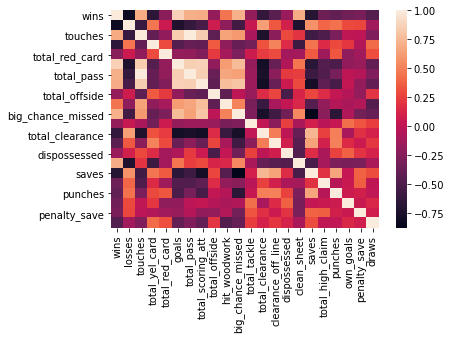

In [83]:
sns.heatmap(matrix)

## 3. szakasz: Győzelem - támadójáték - védelem

### Binnelt változók létrehozása

In [9]:
pandas_adat.loc[:, "binned_tackles"] = (
    pd.cut(pandas_adat["total_tackle"].astype(int), bins=np.linspace(400, 620, 12))
    .apply(lambda x: int(x.right))
    .values
)
pandas_adat.loc[:, "binned_saves"] = (
    pd.cut(pandas_adat["saves"].astype(int), bins=np.linspace(0, 120, 25))
    .apply(lambda x: int(x.right))
    .values
)

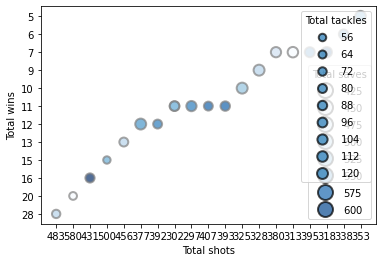

In [10]:
fig, ax = plt.subplots()

scatter = ax.scatter(
    pandas_adat["total_scoring_att"],
    pandas_adat["wins"],
    s=pandas_adat["binned_saves"],
    c=pandas_adat["binned_tackles"],
    cmap="Blues",
    alpha=0.7,
    edgecolors="grey",
    linewidth=2,
)

plt.xlabel("Total shots")
plt.ylabel("Total wins")

color_legend = ax.legend(
    *scatter.legend_elements(prop="colors", size=15, markeredgecolor="black"),
    loc="lower right",
    title="Total saves"
)

ax.add_artist(color_legend)

size_legend = ax.legend(
    *scatter.legend_elements(prop="sizes", color=None, markeredgecolor="black"),
    loc="upper right",
    title="Total tackles"
)

## 4. szakasz: Győzelem - Csatársor - Középpálya - Védősor - Kapusok

In [85]:
kispandas= pandas_adat[["wins","total_scoring_att","total_pass", "total_tackle","saves"]]

In [86]:
kispandas = kispandas.reset_index()

In [87]:
kispandas["wins"] = kispandas["wins"]/kispandas["wins"].mean(axis=0)
kispandas["total_scoring_att"] = kispandas["total_scoring_att"]/kispandas["total_scoring_att"].mean(axis=0)
kispandas["total_pass"] = kispandas["total_pass"]/kispandas["total_pass"].mean(axis=0)
kispandas["total_tackle"] = kispandas["total_tackle"]/kispandas["total_tackle"].mean(axis=0)
kispandas["saves"] = kispandas["saves"]/kispandas["saves"].mean(axis=0)

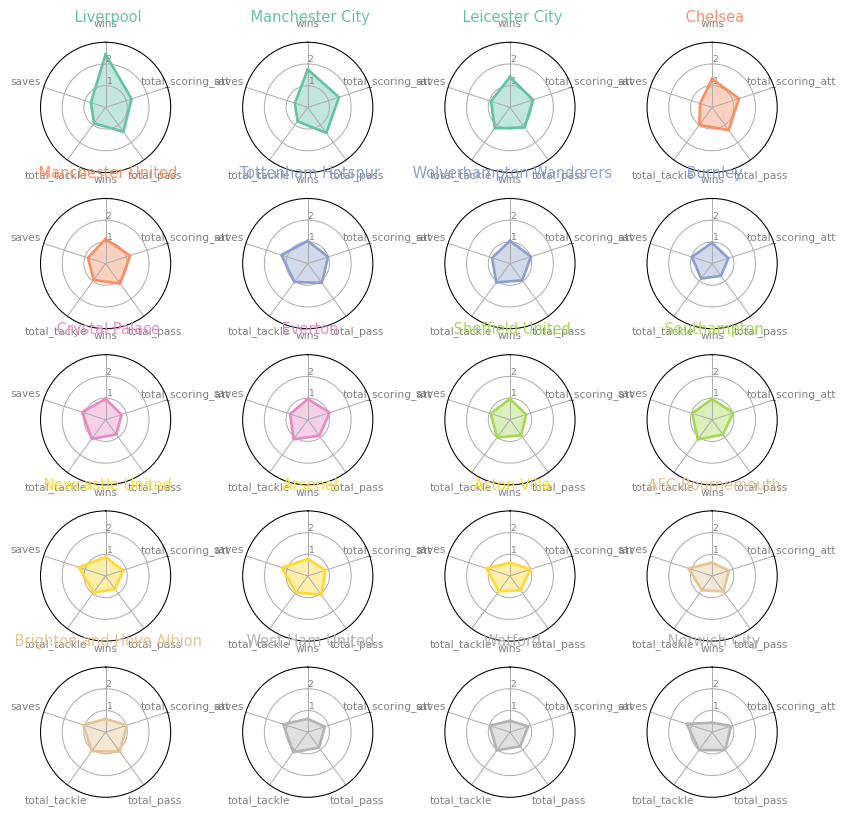

In [97]:
df = kispandas
def make_spider( row, title, color):
    categories=list(df)[1:]
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(5,4,row+1, polar=True, )
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks([1,2], ["1","2"], color="grey", size=7)
    plt.ylim(0,3)
    values=df.loc[row].drop('index').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    plt.title(title, size=11, color=color, y=1.1)

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
my_palette = plt.cm.get_cmap("Set2", len(df.index))

for row in range(0, len(df.index)):
    make_spider( row=row, title=df['index'][row], color=my_palette(row))
